In [1]:
import torch
import random
from PIL import Image
import numpy as np
from numpy import int64
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import os
import glob
drive.mount('/gdrive')
root = '/gdrive/My Drive/'

Mounted at /gdrive


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#write your own ways on google drive or your local PC

data_root = '/gdrive/My Drive/GPO/dataset/'
test_path = "/gdrive/My Drive/GPO/dataset/test/tags/"
train_img_path = "/gdrive/My Drive/GPO/dataset/train/tags/"
train_mask_path = "/gdrive/My Drive/GPO/dataset/train/price_card_mask/" #
test_mask_path = "/gdrive/My Drive/GPO/dataset/test/price_card_mask/" #
'''
data_root = '/gdrive/MyDrive/ГПО/Датасет/dataset 512/dataset/'
test_path = "/gdrive/MyDrive/ГПО/Датасет/dataset 512/dataset/test/tags/"
train_img_path = "/gdrive/MyDrive/ГПО/Датасет/dataset 512/dataset/train/tags/"
train_mask_path = "/gdrive/MyDrive/ГПО/Датасет/dataset 512/dataset/train/price_card_mask/" #
test_mask_path = "/gdrive/MyDrive/ГПО/Датасет/dataset 512/dataset/test/price_card_mask/" #
'''
train_dir = 'tags'
mask_dir = 'price_card_mask'
test_dir = 'test'
random.seed(0)
np.random.seed(0)

In [ ]:
!pip install imageio

In [ ]:
from imageio import imread
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
#x - tags, у - masks

x1 = []
x2 = []
y1 = []
y2 = []

In [ ]:
#you can get dataset via google drive: https://drive.google.com/file/d/13m6woHitEQHrvWEwvP3oL4o-CQULC0vv/view?usp=sharing

for fl1 in sorted(os.listdir(train_img_path)):
    img =np.array(imread(train_img_path + fl1))
    img = tf.convert_to_tensor(img)
    img = tf.cast(img, tf.float32) / 255.0
    #img = tf.image.crop_to_bounding_box(img, 127, 127, 128, 128)
    x1.append(img)
for fl2 in sorted(os.listdir(train_mask_path)):
    mask = cv2.imread(train_mask_path + fl2,0)
    ret,thresh = cv2.threshold(mask,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    y1.append(tf.convert_to_tensor(np.array([y, x, h, w])/256))
for fl3 in sorted(os.listdir(test_path)):
    test_img = imread(test_path + fl3)
    test_img = tf.convert_to_tensor(np.array(test_img))
    test_img = tf.cast(test_img, tf.float32) / 255.0
    #test_img = tf.image.crop_to_bounding_box(test_img, 127, 127, 128, 128)
    x2.append(test_img)
for fl4 in sorted(os.listdir(test_mask_path)):
    mask = cv2.imread(test_mask_path + fl4,0)
    ret,thresh = cv2.threshold(mask,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    y2.append(tf.convert_to_tensor(np.array([y, x, h, w])/256))

111 194 136 49
(1, 256, 256, 3)


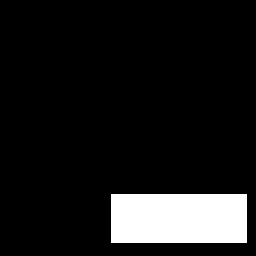

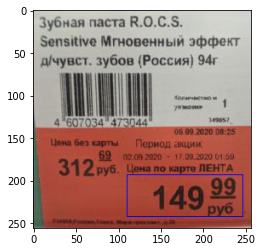

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img_o = None
mask = None
for fl1 in sorted(os.listdir(train_img_path)):
    img_o = cv2.imread(train_img_path + fl1)
    break
for fl2 in sorted(os.listdir(train_mask_path)):
    mask = cv2.imread(train_mask_path + fl2,0)
    ret,thresh = cv2.threshold(mask,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    print(x, y, w, h)
    img = tf.image.crop_to_bounding_box(x1[0], y, x, h, w)
    box = np.array([y, x, y+h, x+w])/256
    boxes = box.reshape([1, 1, 4])
    colors = np.array([[0.0, 0.0, 1.0], [0.0, 0.0, 1.0]])
    print(tf.expand_dims(x1[0], axis=0).shape)
    img = tf.image.draw_bounding_boxes(tf.expand_dims(x1[0], axis=0), boxes, colors)
    break
cv2_imshow(mask)
plt.imshow(img[0])

In [ ]:
train = tf.data.Dataset.from_tensor_slices((x1, y1))
test = tf.data.Dataset.from_tensor_slices((x2, y2))
train_dataset = train.batch(5)
test_dataset = test.batch(1)

In [ ]:
len(train)

143

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
print(train.take(1))

<TakeDataset shapes: ((256, 256, 3), (4,)), types: (tf.float32, tf.float64)>


In [ ]:
for kappa in range(1):
  for image, mask in train.take(kappa):
    sample_image, sample_mask = image, mask
    y, x, h, w = sample_mask.numpy()
    box = np.array([y, x, y+h, x+w])
    boxes = box.reshape([1, 1, 4])
    colors = np.array([[0.0, 0.0, 1.0], [0.0, 0.0, 1.0]])
    mask = tf.image.draw_bounding_boxes(tf.expand_dims(sample_image, axis=0), boxes, colors)[0]
  print(sample_image.shape)
  print(mask.shape)
  display([sample_image, mask])

In [ ]:
for kappa in range(1, 10):
  for image, mask in test.take(kappa):
    sample_image, sample_mask = image, mask
    y, x, h, w = sample_mask.numpy()
    box = np.array([y, x, y+h, x+w])
    boxes = box.reshape([1, 1, 4])
    colors = np.array([[0.0, 0.0, 1.0], [0.0, 0.0, 1.0]])
    mask = tf.image.draw_bounding_boxes(tf.expand_dims(sample_image, axis=0), boxes, colors)[0]
  print(sample_image.shape)
  print(mask.shape)
  display([sample_image, mask])

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG16, ResNet152V2, NASNetLarge
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import numpy as np
import cv2
import os

In [ ]:
# load model and specify a new input shape for images
new_input = Input(shape=(256, 256, 3))
vgg = VGG16(include_top=False, input_tensor=new_input)
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)
bboxHead = Dense(4096, activation="relu")(flatten)
bboxHead = Dense(2048, activation="relu")(bboxHead)
bboxHead = Dense(1024, activation="relu")(bboxHead)
bboxHead = Dense(512, activation="relu")(bboxHead)
bboxHead = Dense(256, activation="relu")(bboxHead)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dropout(0.1)(bboxHead)
bboxHead = Dense(4)(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from keras import backend as K

def dice_coef (y_true, y_pred, smooth=1):
  y_true_f = K.klatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IoU(y_true, y_pred):
  y_true_f = K.klatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
  return intersection/union

In [ ]:

optim = tf.keras.optimizers.Adagrad()
model.compile(optimizer=optim,
              loss=tf.keras.losses.MeanAbsolutePercentageError(),
              #loss=tf.keras.losses.LogCosh(),
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
              #metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

'''
model.compile(optimizer='sgd',
              loss=tf.keras.losses.MeanAbsolutePercentageError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])
'''

"\nmodel.compile(optimizer='sgd',\n              loss=tf.keras.losses.MeanAbsolutePercentageError(),\n              metrics=[tf.keras.metrics.MeanAbsoluteError()])\n"

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
coord_array=[]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(num)
      pred_mask = model.predict(image)
      y, x, h, w = pred_mask[0]
      box = np.array([y, x, y+h, x+w])
      boxes = box.reshape([1, 1, 4])
      colors = np.array([[0.0, 0.0, 1.0], [0.0, 0.0, 1.0]])
      predicted = tf.image.draw_bounding_boxes(tf.expand_dims(image[0], axis=0), boxes, colors)[0]
      y, x, h, w = mask[0].numpy()
      box = np.array([y, x, y+h, x+w])
      print(box)
      boxes = box.reshape([1, 1, 4])
      colors = np.array([[0.0, 0.0, 1.0], [0.0, 0.0, 1.0]])
      mask_box = tf.image.draw_bounding_boxes(tf.expand_dims(image[0], axis=0), boxes, colors)[0]
      display([image[0], mask_box, predicted])
  else:
    pred_mask = model.predict(sample_image)
    y, x, h, w = pred_mask[0]
    box = np.array([y, x, y+h, x+w])
    boxes = box.reshape([1, 1, 4])
    colors = np.array([[0.0, 0.0, 1.0], [0.0, 0.0, 1.0]])
    predicted = tf.image.draw_bounding_boxes(tf.expand_dims(sample_image, axis=0), boxes, colors)[0]
    y, x, h, w = sample_mask.numpy()
    box = np.array([y, x, y+h, x+w])/255
    boxes = box.reshape([1, 1, 4])
    colors = np.array([[0.0, 0.0, 1.0], [0.0, 0.0, 1.0]])
    mask_box = tf.image.draw_bounding_boxes(tf.expand_dims(sample_image, axis=0), boxes, colors)[0]
    display([sample_image, mask_box,
             predicted])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 50
vgg.trainable = True
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          validation_data=test_dataset)

Epoch 1/50
29/29 [==============================] - 4s 138ms/step - loss: 263.4985 - mean_absolute_percentage_error: 263.4985 - val_loss: 9.6421 - val_mean_absolute_percentage_error: 9.6421
Epoch 2/50
29/29 [==============================] - 2s 68ms/step - loss: 29.6434 - mean_absolute_percentage_error: 29.6434 - val_loss: 37.1856 - val_mean_absolute_percentage_error: 37.1856
Epoch 3/50
29/29 [==============================] - 2s 68ms/step - loss: 24.3938 - mean_absolute_percentage_error: 24.3938 - val_loss: 15.9441 - val_mean_absolute_percentage_error: 15.9441
Epoch 4/50
29/29 [==============================] - 2s 70ms/step - loss: 20.3486 - mean_absolute_percentage_error: 20.3486 - val_loss: 17.4557 - val_mean_absolute_percentage_error: 17.4557
Epoch 5/50
29/29 [==============================] - 2s 69ms/step - loss: 20.3293 - mean_absolute_percentage_error: 20.3293 - val_loss: 18.2467 - val_mean_absolute_percentage_error: 18.2467
Epoch 6/50
29/29 [==============================] - 2s

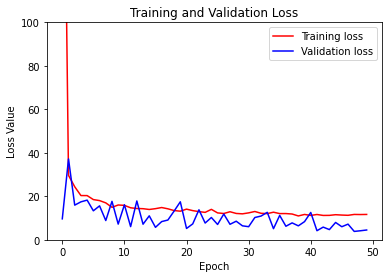

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 100])
plt.legend()
plt.show()

LOADING THE WEIGHTS

In [ ]:
#you can get pre-trained weights via google drive: https://drive.google.com/file/d/1XRiR_AM4IHvVae_rEUh-avA_s8AbZwKN/view?usp=sharing

model.load_weights('/gdrive/MyDrive/GPO/weights/VGG16/vgg16_1.h5')

RESAULTS

21
[0.7578125  0.43359375 0.94921875 0.96484375]


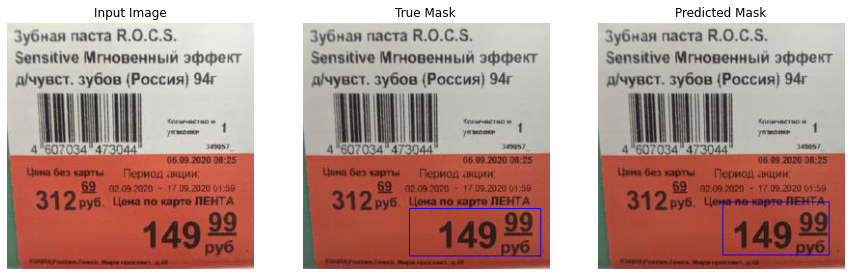

21
[0.6953125  0.4453125  0.91796875 0.92578125]


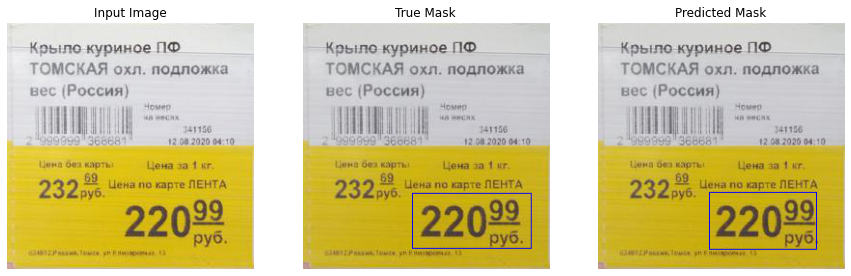

21
[0.69140625 0.4375     0.91796875 0.890625  ]


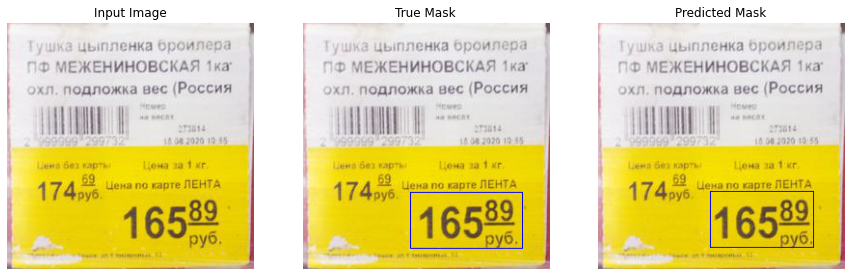

21
[0.71875    0.44921875 0.92578125 0.88671875]


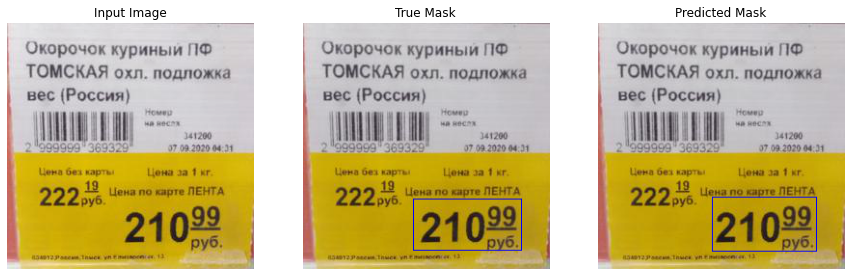

21
[0.71875    0.43359375 0.94140625 0.8984375 ]


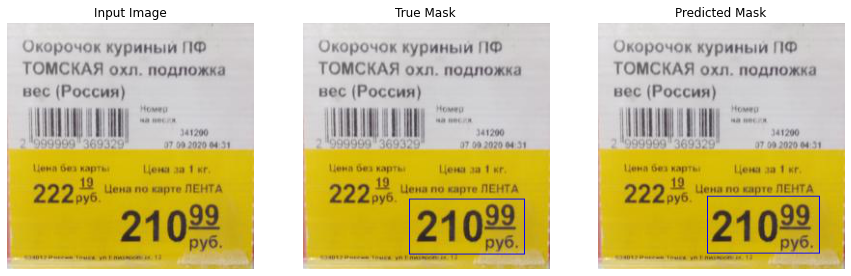

21
[0.68359375 0.43359375 0.8984375  0.8984375 ]


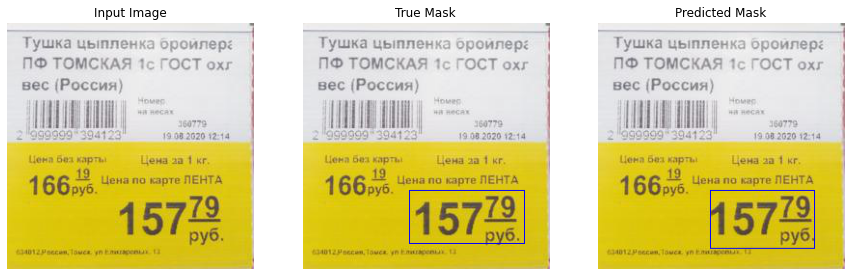

21
[0.67578125 0.4140625  0.91015625 0.91015625]


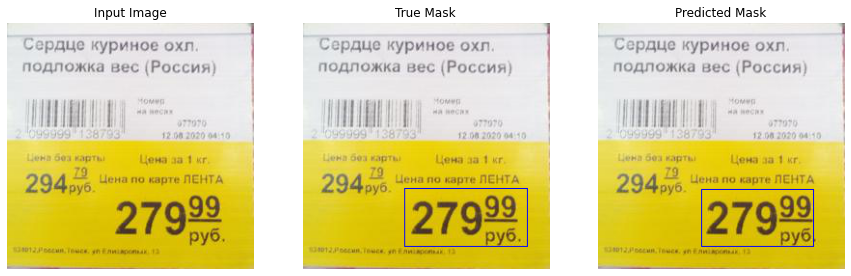

21
[0.71484375 0.55078125 0.94140625 0.91015625]


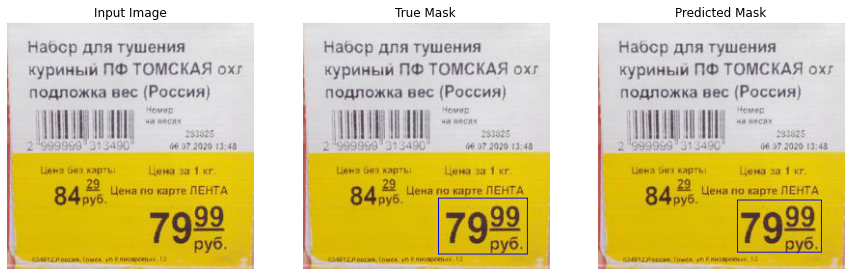

21
[0.71484375 0.51953125 0.93359375 0.90234375]


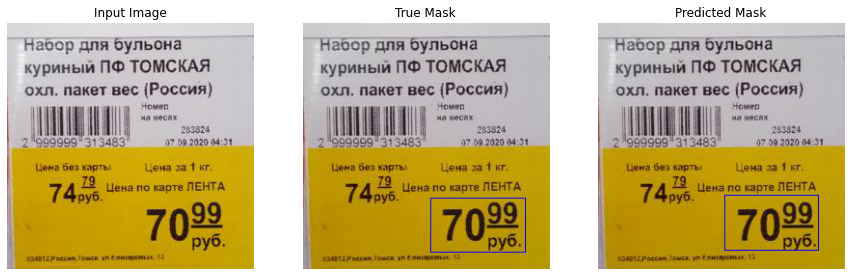

21
[0.703125   0.53125    0.93359375 0.9140625 ]


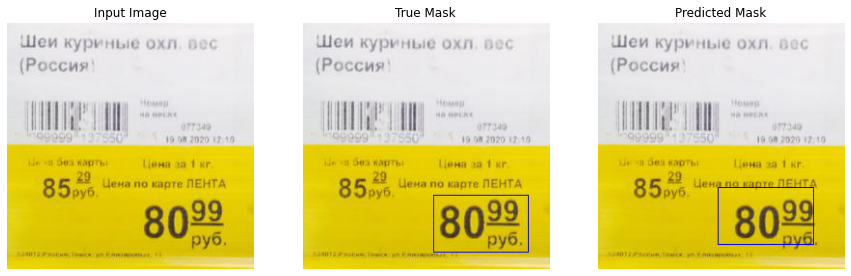

21
[0.70703125 0.41015625 0.92578125 0.84765625]


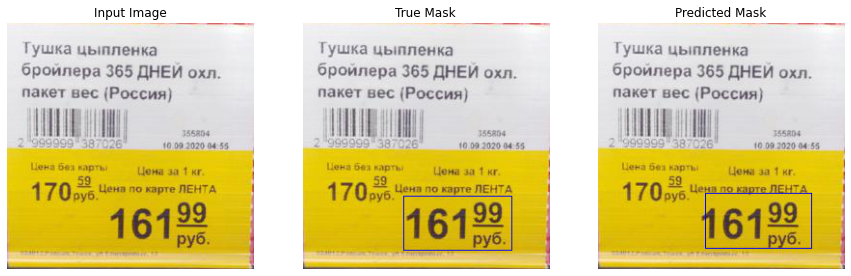

21
[0.70703125 0.37890625 0.92578125 0.80859375]


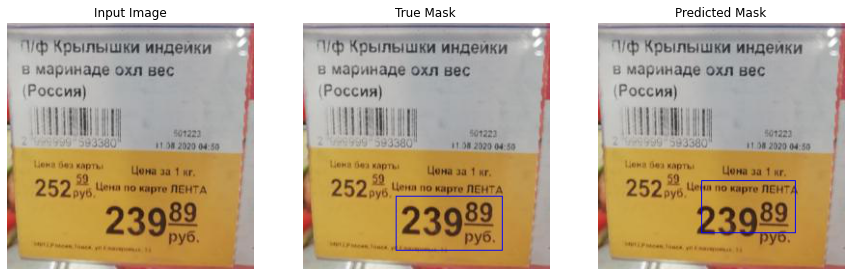

21
[0.703125   0.4140625  0.921875   0.87109375]


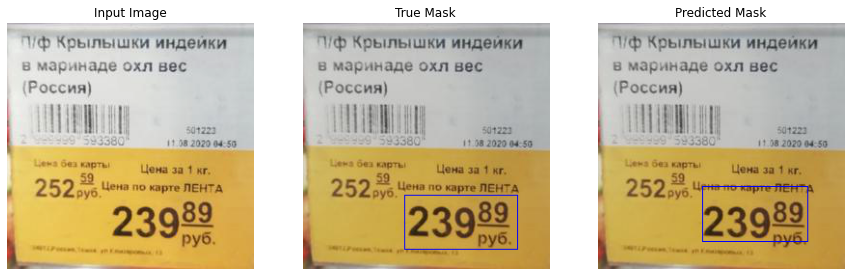

21
[0.69921875 0.4609375  0.92578125 0.91015625]


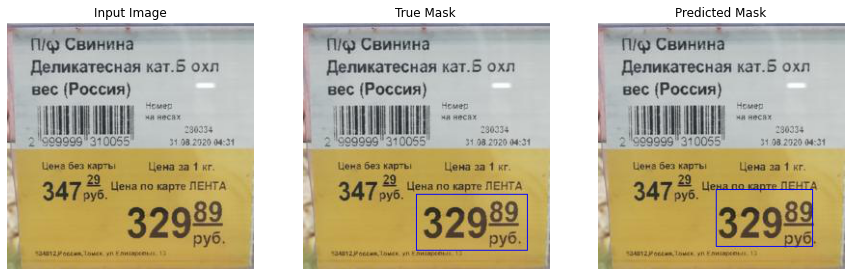

21
[0.71875    0.390625   0.9375     0.86328125]


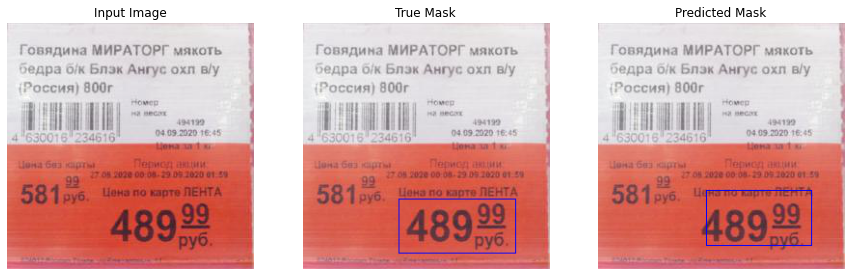

21
[0.69140625 0.44921875 0.921875   0.90234375]


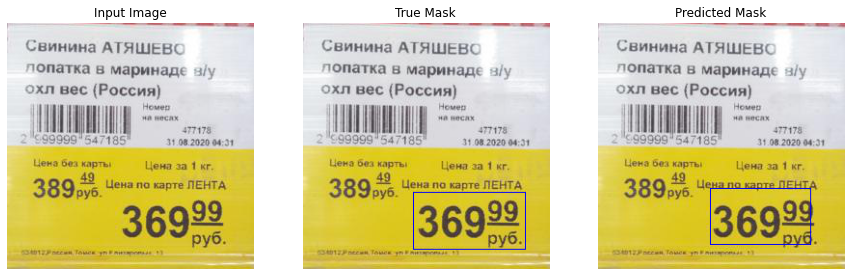

21
[0.71484375 0.44921875 0.93359375 0.90234375]


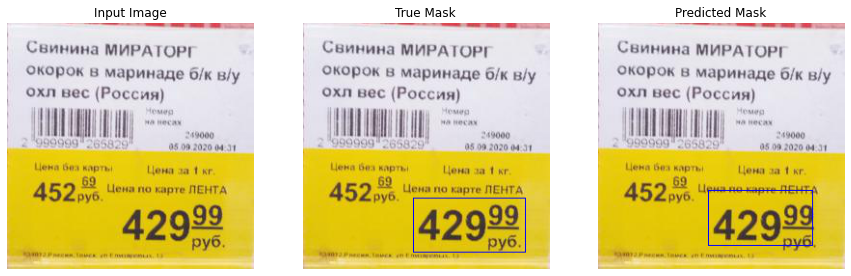

21
[0.703125   0.4375     0.9375     0.88671875]


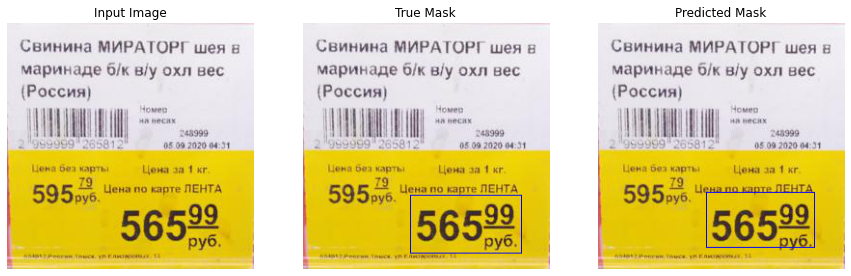

21
[0.71484375 0.4609375  0.93359375 0.91015625]


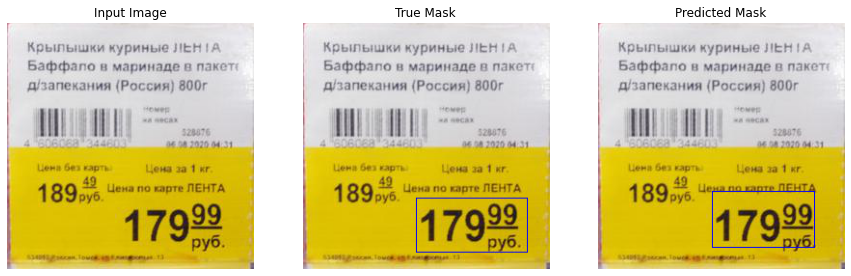

21
[0.69140625 0.45703125 0.9296875  0.91796875]


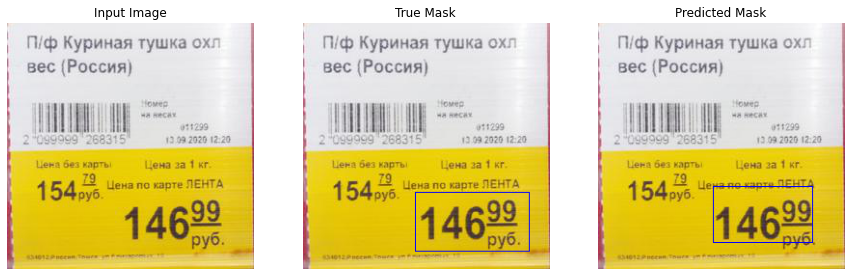

In [ ]:
show_predictions(test_dataset, 21)

SAVING THE WEIGHTS

In [ ]:
model.save_weights('/gdrive/MyDrive/GPO/weights/VGG16/vgg16_256.h5')

CRAFT

In [ ]:
!pip install keras-ocr

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from imageio import imread

     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 9.5MB 9.2MB/s 
     |████████████████████████████████| 860kB 49.1MB/s 
     |████████████████████████████████| 133kB 55.2MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.7-cp37-none-any.whl size=43749 sha256=c8d5e79dca004f6526571874a43a232bd6994650b48b277d9e90fc1e6d8a6803
  Stored in directory: /root/.cache/pip/wheels/45/9b/2b/d48a7f3387eb3701e4e7f27d0a31cfe38bca24ef53a7fe8d2f
Successfully built keras-ocr


In [ ]:
from keras.preprocessing.image import save_img
k = 0

In [ ]:
crop_array=[]
def show_predictions_cropping(dataset=None, num=1):
  k=0
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      y, x, h, w = pred_mask[0]
      y1, x1, h1, w1 = pred_mask[0]
      print(round(y*256), round(x*256), round(h*256), round(w*256))
      box = np.array([y, x, y+h, x+w])
      boxes = box.reshape([1, 1, 4])
      colors = np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
      predicted = tf.image.draw_bounding_boxes(tf.expand_dims(image[0], axis=0), boxes, colors)[0]
      y, x, h, w = mask[0].numpy()
      box = np.array([y, x, y+h, x+w])
      print(box)
      crop_array.append(box)
      boxes = box.reshape([1, 1, 4])
      colors = np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
      mask_box = tf.image.draw_bounding_boxes(tf.expand_dims(image[0], axis=0), boxes, colors)[0]
      print(boxes)
      cropped_image = tf.image.crop_to_bounding_box(image[0], round(y1*256), round(x1*256), round(h1*256), round(w1*256))
      save_img("/gdrive/MyDrive/GPO/dataset/croped4/"+str(k)+"_cropped.jpg", cropped_image) #create directory and change it's way before starting this cell
      k=k+1
      display([cropped_image])
  else:
    pred_mask = model.predict(sample_image)
    y, x, h, w = pred_mask[0]
    box = np.array([y, x, y+h, x+w])
    boxes = box.reshape([1, 1, 4])
    colors = np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    predicted = tf.image.draw_bounding_boxes(tf.expand_dims(sample_image, axis=0), boxes, colors)[0]
    y, x, h, w = sample_mask.numpy()
    box = np.array([y, x, y+h, x+w])
    boxes = box.reshape([1, 1, 4])
    colors = np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    mask_box = tf.image.draw_bounding_boxes(tf.expand_dims(sample_image, axis=0), boxes, colors)[0]
    display([sample_image, mask_box,
             predicted])

187 130 55 111
[0.7578125  0.43359375 0.94921875 0.96484375]
[[[0.7578125  0.43359375 0.94921875 0.96484375]]]


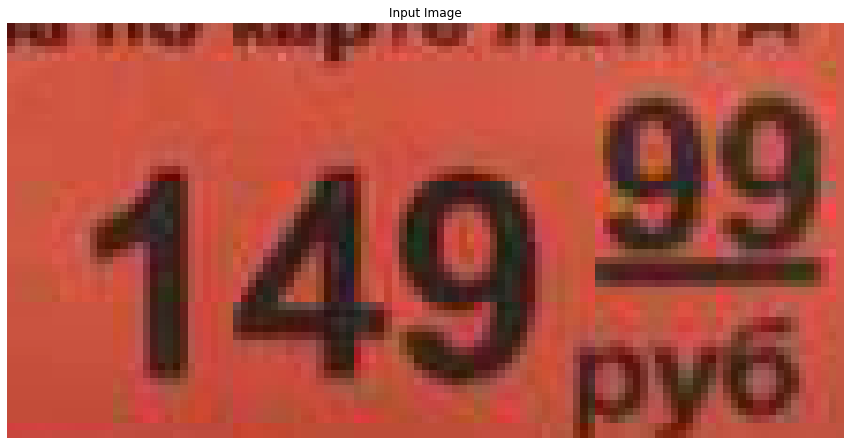

178 116 59 111
[0.6953125  0.4453125  0.91796875 0.92578125]
[[[0.6953125  0.4453125  0.91796875 0.92578125]]]


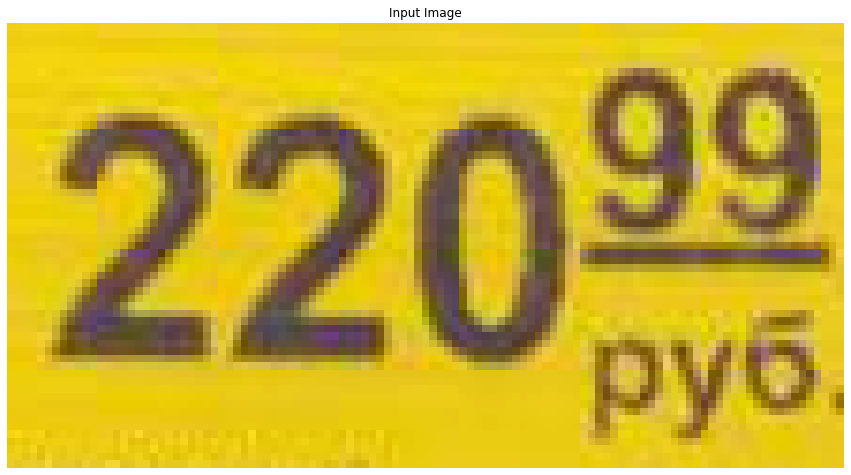

176 117 58 108
[0.69140625 0.4375     0.91796875 0.890625  ]
[[[0.69140625 0.4375     0.91796875 0.890625  ]]]


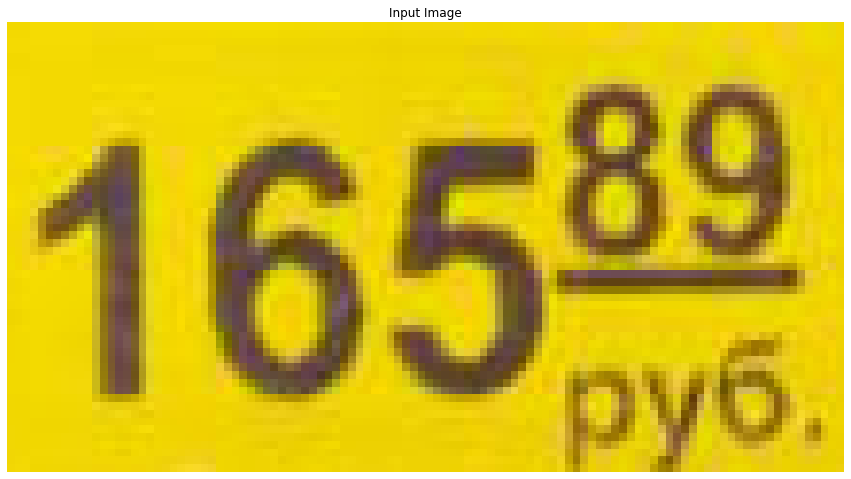

182 119 57 109
[0.71875    0.44921875 0.92578125 0.88671875]
[[[0.71875    0.44921875 0.92578125 0.88671875]]]


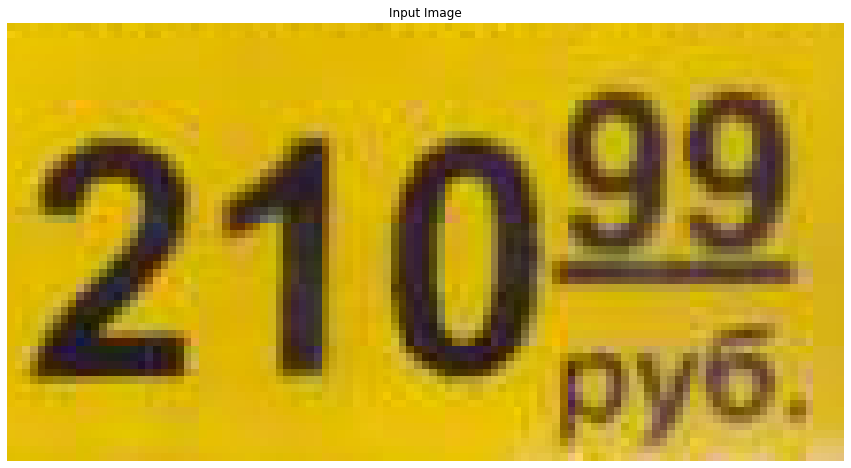

181 114 59 116
[0.71875    0.43359375 0.94140625 0.8984375 ]
[[[0.71875    0.43359375 0.94140625 0.8984375 ]]]


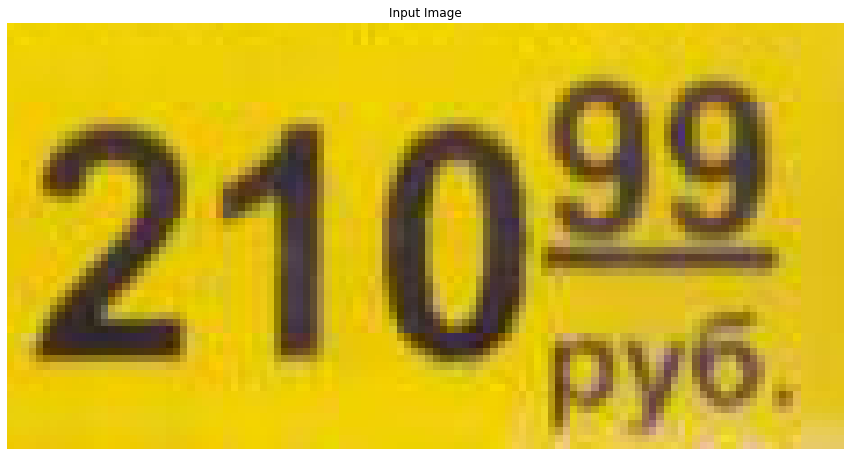

175 117 60 109
[0.68359375 0.43359375 0.8984375  0.8984375 ]
[[[0.68359375 0.43359375 0.8984375  0.8984375 ]]]


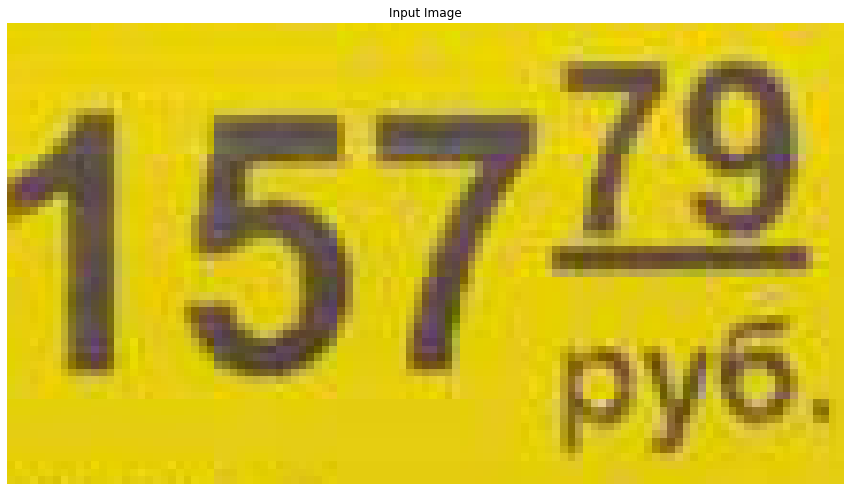

174 108 59 116
[0.67578125 0.4140625  0.91015625 0.91015625]
[[[0.67578125 0.4140625  0.91015625 0.91015625]]]


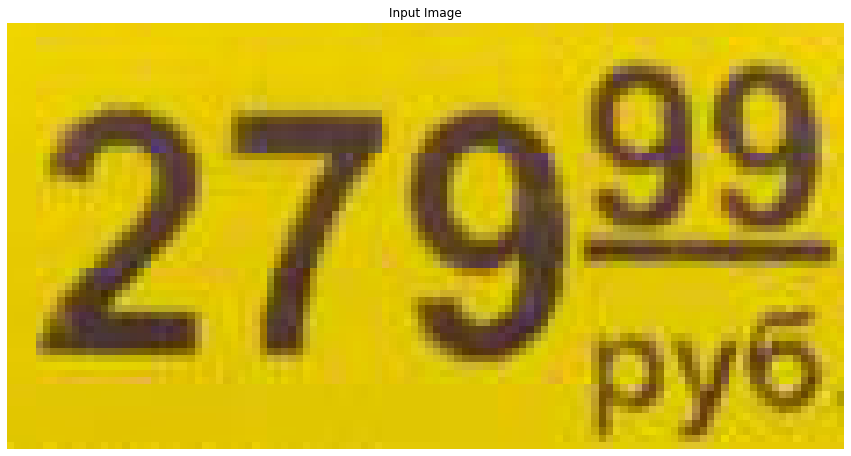

185 145 55 87
[0.71484375 0.55078125 0.94140625 0.91015625]
[[[0.71484375 0.55078125 0.94140625 0.91015625]]]


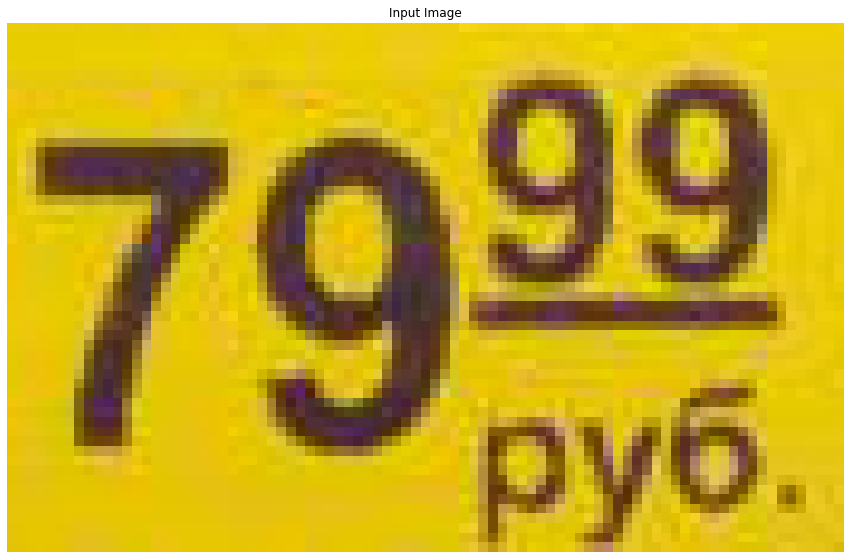

180 132 57 97
[0.71484375 0.51953125 0.93359375 0.90234375]
[[[0.71484375 0.51953125 0.93359375 0.90234375]]]


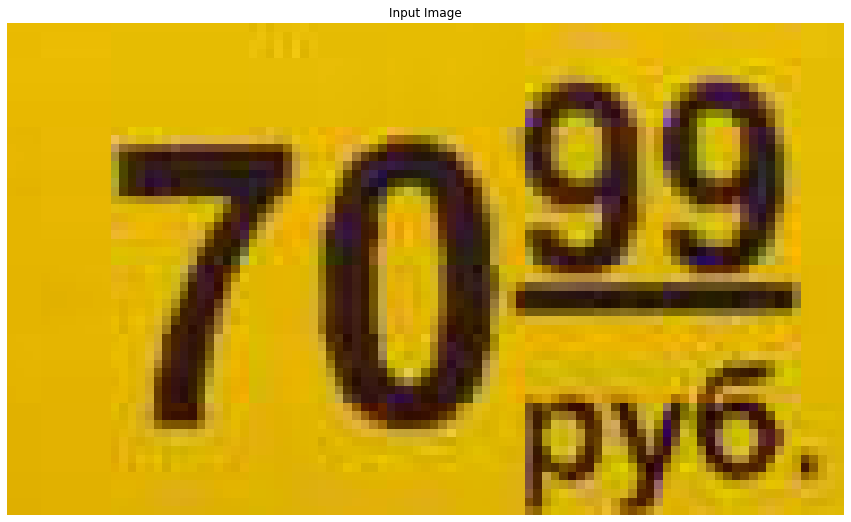

172 125 60 99
[0.703125   0.53125    0.93359375 0.9140625 ]
[[[0.703125   0.53125    0.93359375 0.9140625 ]]]


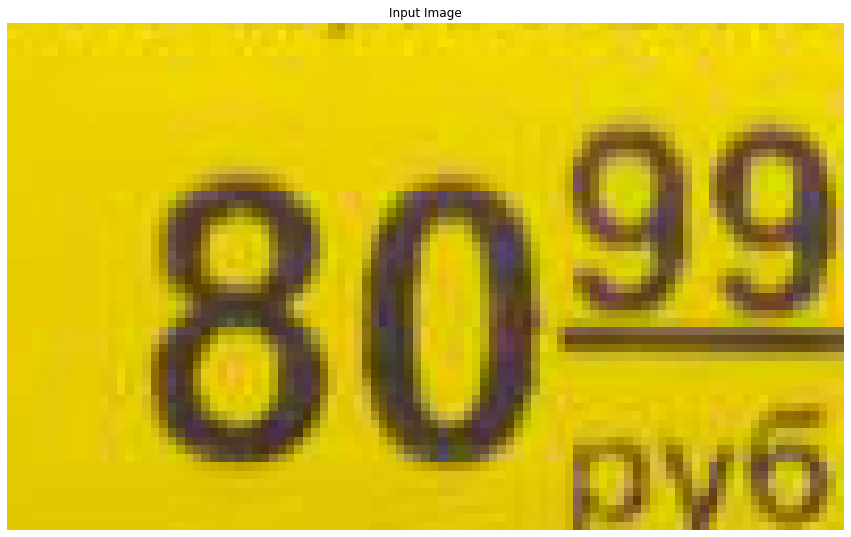

178 112 57 110
[0.70703125 0.41015625 0.92578125 0.84765625]
[[[0.70703125 0.41015625 0.92578125 0.84765625]]]


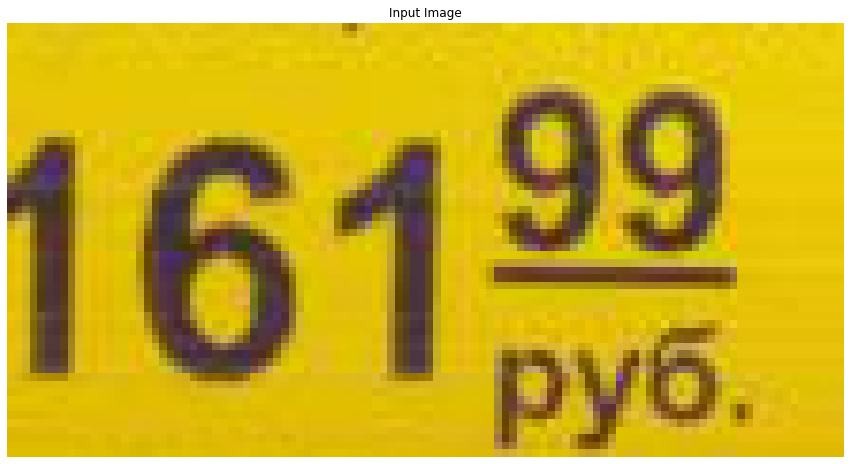

165 107 55 98
[0.70703125 0.37890625 0.92578125 0.80859375]
[[[0.70703125 0.37890625 0.92578125 0.80859375]]]


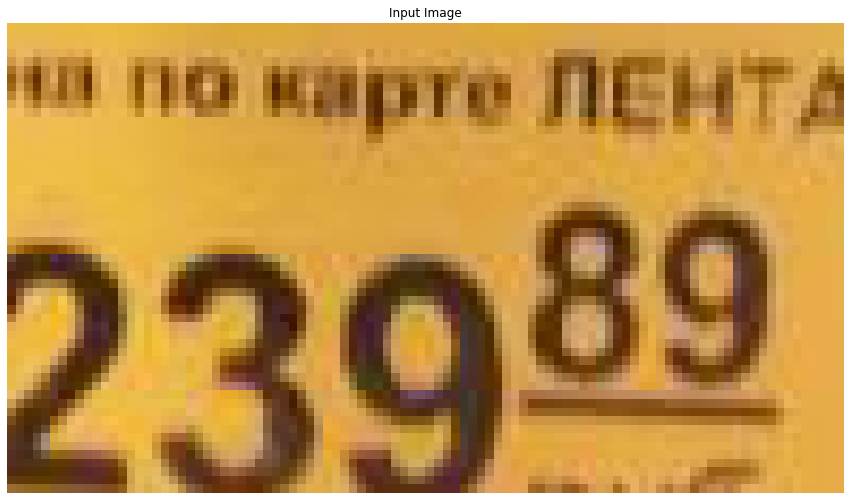

171 109 58 110
[0.703125   0.4140625  0.921875   0.87109375]
[[[0.703125   0.4140625  0.921875   0.87109375]]]


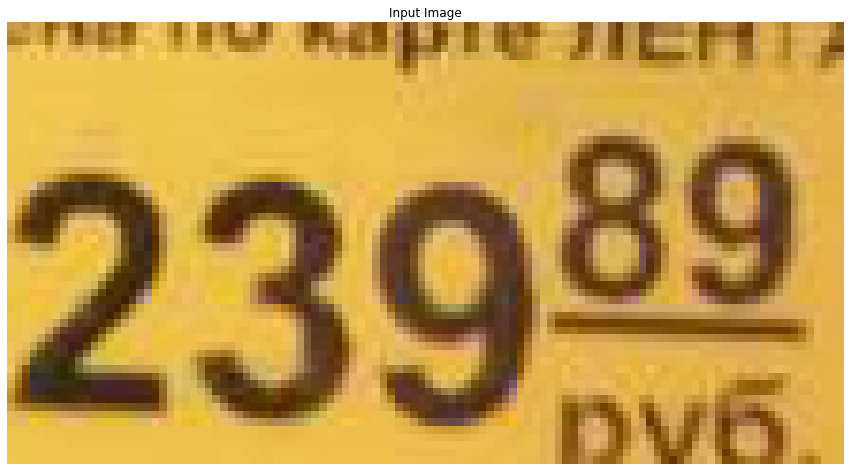

175 123 58 101
[0.69921875 0.4609375  0.92578125 0.91015625]
[[[0.69921875 0.4609375  0.92578125 0.91015625]]]


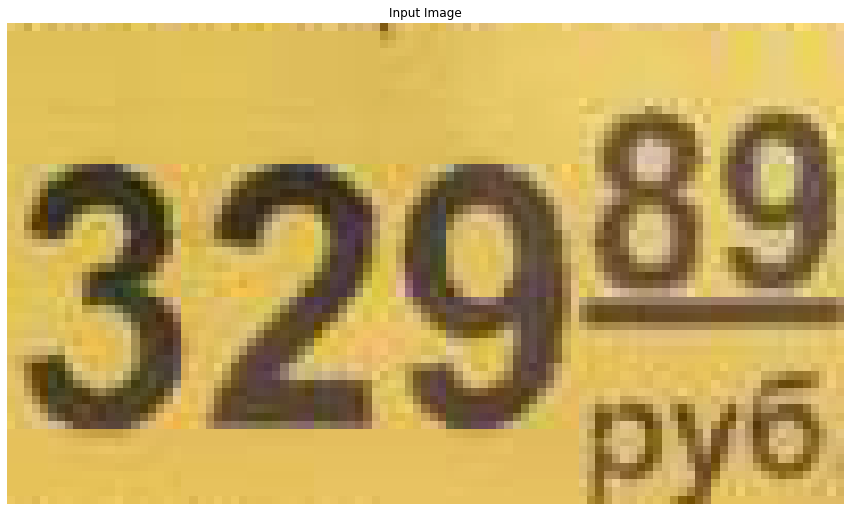

176 113 57 109
[0.71875    0.390625   0.9375     0.86328125]
[[[0.71875    0.390625   0.9375     0.86328125]]]


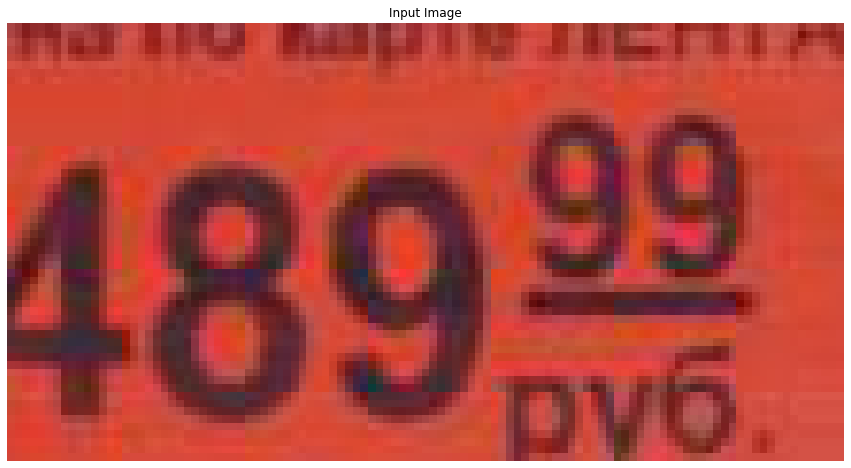

174 117 58 104
[0.69140625 0.44921875 0.921875   0.90234375]
[[[0.69140625 0.44921875 0.921875   0.90234375]]]


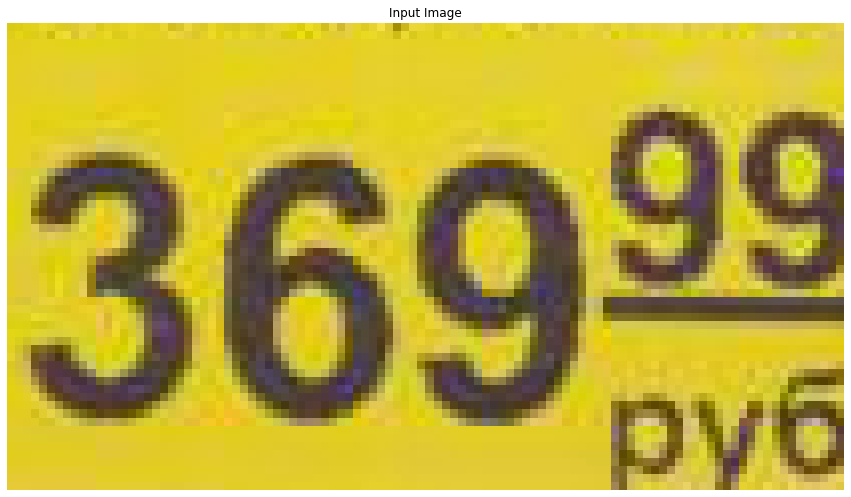

176 115 56 108
[0.71484375 0.44921875 0.93359375 0.90234375]
[[[0.71484375 0.44921875 0.93359375 0.90234375]]]


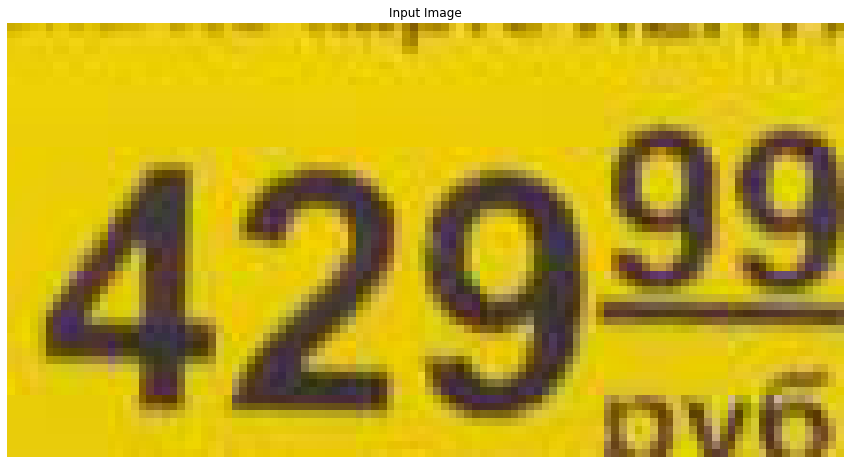

177 113 58 112
[0.703125   0.4375     0.9375     0.88671875]
[[[0.703125   0.4375     0.9375     0.88671875]]]


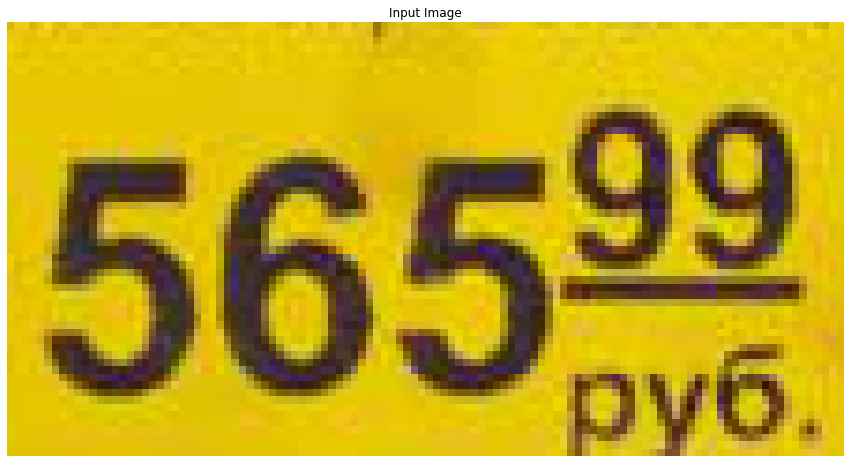

176 119 58 106
[0.71484375 0.4609375  0.93359375 0.91015625]
[[[0.71484375 0.4609375  0.93359375 0.91015625]]]


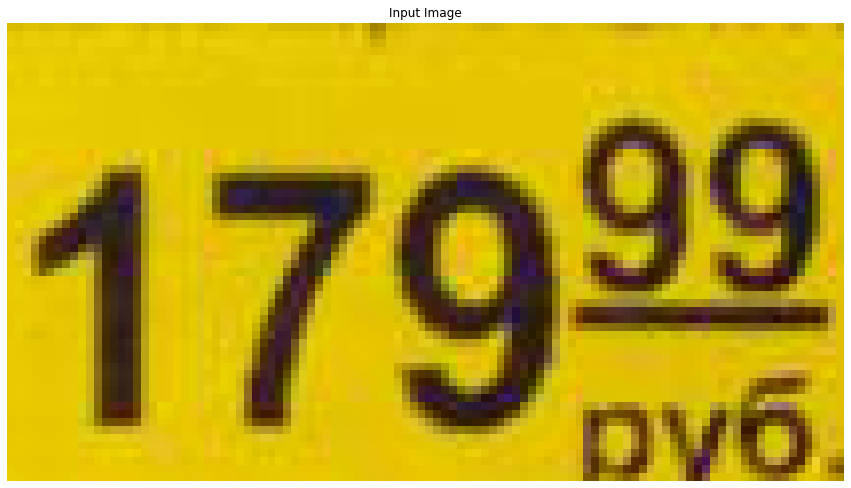

172 120 58 103
[0.69140625 0.45703125 0.9296875  0.91796875]
[[[0.69140625 0.45703125 0.9296875  0.91796875]]]


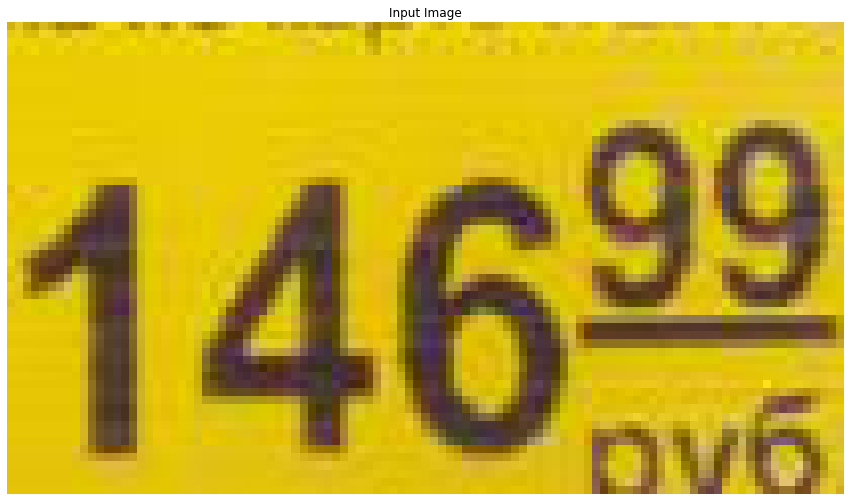

In [ ]:
show_predictions_cropping(test_dataset, 21)

In [ ]:
import keras_ocr
import string
data_dir = '/gdrive/MyDrive/GPO/'

#alphabet = string.digits + string.ascii_letters + '!?. '
#alphabet = string.digits + string.ascii_letters + string.punctuation + 'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'
#alphabet = string.digits + string.ascii_letters + '!?.' + 'БбвГгДдЁёЖжЗзИиЙйЛлПпФфЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'
#alphabet = string.digits + 'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'
alphabet = string.digits
recognizer_alphabet = alphabet
#recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir
)

detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet
    #weights='kurapan'
)
recognizer.compile()

for layer in recognizer.backbone.layers:
    layer.trainable = False

Looking for /gdrive/MyDrive/GPO/fonts.zip


Filtering fonts.: 100%|██████████| 2746/2746 [16:14<00:00,  2.82it/s]


Looking for /root/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [ ]:
#you can get pre-trained weights via google drive:
# 1 https://drive.google.com/file/d/19NgEhS_ckwP-VRNrBoc73n554NuVXHjv/view?usp=sharing - end-to-end learning, digits only
# 2 https://drive.google.com/file/d/1rbNdNSWi1JkM2JgGzdopUqEyu1IFGtYg/view?usp=sharing - transfer learning, digits only
# 3 https://drive.google.com/file/d/1fA1KlwM5vWGUNjbyiUZuI7p8BmOo0aW5/view?usp=sharing - end-to-end learning, digits and rus
# 4 https://drive.google.com/file/d/1NVOxXCPQ_KOMZFlSmdVsw2R8SfcllvJd/view?usp=sharing - transfer learning, digits and rus
# 5 https://drive.google.com/file/d/1pq8aP2sn5CQW6yzipge5nCFygcnSpWUL/view?usp=sharing - transfer learning, digits, eng and rus

recognizer.model.load_weights('/gdrive/MyDrive/colab/keras-ocr/digits(full learning)_256.h5')

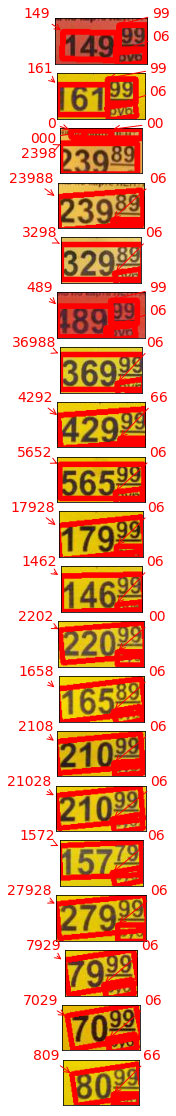

In [ ]:


# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)
cropped_img_path = "/gdrive/MyDrive/GPO/dataset/croped4/"

# Get a set of three example images

images1 = []
for fl5 in sorted(os.listdir(cropped_img_path)):
    img = cropped_img_path+fl5
    images1.append(img)


images = [
    keras_ocr.tools.read(img) for img in images1
]

# Each list of predictions in prediction_groups is a list of
# (word, box) tuples.
prediction_groups = pipeline.recognize(images)

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

In [ ]:
print(pipeline.recognize(images))

[[('22099', array([[  1.7458534,  12.82873  ],
       [111.10762  ,   3.035141 ],
       [114.880005 ,  45.160004 ],
       [  5.5182304,  54.95359  ]], dtype=float32)), ('pyo', array([[ 76.,  40.],
       [110.,  40.],
       [110.,  58.],
       [ 76.,  58.]], dtype=float32))], [('2109', array([[  0.46696472,  20.117138  ],
       [107.80501   ,   8.7328    ],
       [112.24814   ,  50.625202  ],
       [  4.910095  ,  62.00954   ]], dtype=float32)), ('pyo', array([[ 74.,  44.],
       [107.,  44.],
       [107.,  60.],
       [ 74.,  60.]], dtype=float32))], [('16569', array([[ -3.1541138,  15.372816 ],
       [105.28025  ,   2.02705  ],
       [110.55514  ,  44.88552  ],
       [  2.1207733,  58.23129  ]], dtype=float32)), ('pyo', array([[ 69.743996,  44.592003],
       [103.799995,  38.4     ],
       [107.016   ,  56.088005],
       [ 72.96    ,  62.280006]], dtype=float32))], [('21099', array([[ -2.6678123,  17.764805 ],
       [106.949356 ,   8.092701 ],
       [110.74765  ,  5